# Canny edge detector from scratch

## Problem review

Given a free photograph saved as test.jpeg, we have to extract the edges from the image using a custom designed canny edge detector.
This edge detector will be formed in 5 steps:
* Noise reduction
* Gradient calculation
* Non-Maximum suppression
* Double Thresholding
* Hysteresis edge tracking



In [8]:
# All the imports go here
import numpy as np
import os
import cv2
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Input image loading

Here we will visualize the input image for which we have to find the edges

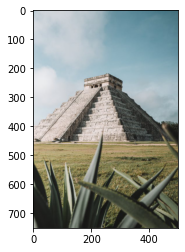

In [9]:
def visualize_input(path=None):
    frame = plt.imread(path)
    plt.imshow(frame)
    
img_name = 'test.jpeg'
visualize_input(img_name)
plt.show()

# Canny detection algorithm:
1. *Noise reduction.* To remove noise, the image is smoothed by Gaussian blur with the kernel of size $5 \times 5$ and $\sigma = 1.4$. Since the sum of the elements in the Gaussian kernel equals $1$, the kernel should be normalized before the convolution. <br><br>

2. *Calculating gradients.* When the image $I$ is smoothed, the derivatives $I_x$ and $I_y$ w.r.t. $x$ and $y$ are calculated. It can be implemented by convolving $I$ with Sobel kernels $K_x$ and $K_y$, respectively:

$$ K_x = \begin{pmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{pmatrix}, K_y = \begin{pmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{pmatrix}. $$ 

Then, the magnitude $G$ and the slope $\theta$ of the gradient are calculated:

$$ |G| = \sqrt{I_x^2 + I_y^2}, $$
$$ \theta(x,y) = arctan\left(\frac{I_y}{I_x}\right)$$<br><br>

3. *Non-maximum suppression.* For each pixel find two neighbors (in the positive and negative gradient directions, supposing that each neighbor occupies the angle of $\pi /4$, and $0$ is the direction straight to the right). If the magnitude of the current pixel is greater than the magnitudes of the neighbors, nothing changes, otherwise, the magnitude of the current pixel is set to zero.<br><br>

4. *Double threshold.* The gradient magnitudes are compared with two specified threshold values, the first one is less than the second. The gradients that are smaller than the low threshold value are suppressed; the gradients higher than the high threshold value are marked as strong ones and the corresponding pixels are included in the final edge map. All the rest gradients are marked as weak ones and pixels corresponding to these gradients are considered in the next step.<br><br>

5. *Edge tracking by hysteresis.* Since a weak edge pixel caused from true edges will be connected to a strong edge pixel, pixel $w$ with weak gradient is marked as edge and included in the final edge map if and only if it is involved in the same blob (connected component) as some pixel $s$ with strong gradient. In other words, there should be a chain of neighbor weak pixels connecting $w$ and $s$ (the neighbors are 8 pixels around the considered one). You are welcome to make up and implement an algorithm that finds all the connected components of the gradient map considering each pixel only once.  After that, you can decide which pixels will be included in the final edge map (this algorithm should be single-pass, as well).

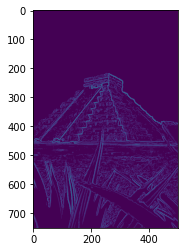

In [17]:
#defining the custom canny detector
def Canny_detector(img,weak_th=None,strong_th=None):
    #conversion of image to grayscale
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    #Noise reduction step
    img=cv2.GaussianBlur(img,(5,5),1.4)
    
    #Calculating the gradients
    gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0,3)
    gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1,3)

    mag, ang = cv2.cartToPolar(gx, gy,angleInDegrees=True)
    
    #setting the minimum and maximum thresholds for double thresholding
    mag_max=np.max(mag)
    if not weak_th:weak_th=mag_max*0.1
    if not strong_th:strong_th=mag_max*0.5   
    height,width=img.shape
    
    for i_x in range(width):
        for i_y in range(height):
            
            grad_ang=ang[i_y,i_x]
            grad_ang=abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
            
            #selecting the neigbours of the target pixel according to the gradient direction
            if grad_ang<=22.5:
                neighb_1_x,neighb_1_y=i_x-1,i_y
                neighb_2_x,neighb_2_y=i_x+1,i_y
            elif grad_ang>22.5 and grad_ang<=(22.5+45):
                neighb_1_x,neighb_1_y=i_x-1,i_y-1
                neighb_2_x,neighb_2_y=i_x+1,i_y+1
            elif grad_ang>(22.5+45) and grad_ang<=(22.5+90):
                neighb_1_x,neighb_1_y=i_x,i_y-1
                neighb_2_x,neighb_2_y=i_x,i_y+1
            elif grad_ang>(22.5+90) and grad_ang<=(22.5+135):
                neighb_1_x,neighb_1_y=i_x-1,i_y+1
                neighb_2_x,neighb_2_y=i_x+1,i_y-1
            elif grad_ang>(22.5+135) and grad_ang<=(22.5+180):
                neighb_1_x,neighb_1_y=i_x-1,i_y
                neighb_2_x,neighb_2_y=i_x+1,i_y
            
            #Non-maximum supression step
            if width>neighb_1_x>=0 and height>neighb_1_y>=0:
                if mag[i_y,i_x]<mag[neighb_1_y,neighb_1_x]:
                    mag[i_y,i_x]=0
                    continue

            if width>neighb_2_x>=0 and height>neighb_2_y>=0:
                if mag[i_y,i_x]<mag[neighb_2_y,neighb_2_x]:
                    mag[i_y,i_x]=0

    weak_ids=zeros_like(img)
    strong_ids=zeros_like(img)              
    ids=zeros_like(img)
    
    #double thresholding step
    for i_x in range(width):
        for i_y in range(height):
            grad_mag=mag[i_y,i_x]
            if grad_mag<weak_th:
                mag[i_y,i_x]=0
            elif strong_th>grad_mag>=weak_th:
                ids[i_y,i_x]=1
            else:
                ids[i_y,i_x]=2
    
    
    
    return mag

In [ ]:
#calling the designed function for finding edges
canny_img = Canny_detector(frame)

#Displaying the output image  
plt.imshow(canny_img)
plt.show()

In [ ]:
#Saving the output image as output.jpeg
cv2.imwrite("output.jpeg",canny_img)